In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymaid
import logging
import random
from graspologic.match import graph_match
from graspologic.simulations import er_np
from graspologic.utils import is_unweighted
from numpy.random import default_rng
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations_v2, load_connectome_normal_lcc_annotations_v3, load_connectome_lcc_normal_adj, load_left_adj, load_right_adj, load_left_adj_labels_with_class_v2, load_right_adj_labels_with_class_v2, load_head_adj_labels_with_class_v2, load_pygidium_adj_labels_with_class_v2, load_0_adj, load_1_adj_labels_with_class_v2, load_2_adj_labels_with_class_v2, load_3_adj_labels_with_class_v2, load_left_adj_labels_with_class_v3, load_right_adj_labels_with_class_v3

         7501  10536  6743  151847  12115  11135  11731  13459  14162  58877  \
7501      0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10536     1.0    0.0   2.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6743      0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
151847    0.0    0.0   1.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12115     0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    1.0   
...       ...    ...   ...     ...    ...    ...    ...    ...    ...    ...   
1310016   0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1732125   0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1415385   0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
708228    0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
941766    0.0    0.0   0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         ...  1420496  135113  1797187 

In [20]:
folder = _get_folder()

rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

type(folder)

pathlib.PosixPath

In [36]:
test = pymaid.get_skids_by_annotation("connectome")
len(test)

2542

Grab Nadine's pairs: these are the true pairs

In [3]:
folder = "/Users/kareefullah/Desktop/naomi-pairwise.xlsx"
true_df = pd.read_excel(folder, dtype=str)

#need to subset true_pairs for the pairs that have left and right entries in their row
true_pairs = true_df[["skid-ID LEFT", "skid-ID RIGHT"]]

#subset true_pairs to not include pairs of neurons that do not have a match
true_pairs = true_pairs[~true_pairs.isnull().any(axis=1)].reset_index()
left_true = list(true_pairs["skid-ID LEFT"])
right_true = list(true_pairs["skid-ID RIGHT"])
true_pairs

,index,skid-ID LEFT,skid-ID RIGHT
0,0,7501,25010
1,1,10536,26163
2,2,6743,23921
3,3,151847,27064
4,4,12115,27917
...,...,...,...
288,669,1326008,1359694
289,670,1717565,1330831
290,671,493317,1299058
291,672,1855933,111948


Load in the left and right adjacency matrices (each neuron in both adjacencies has an associated class label)

In [4]:
left_adj, left_labels = load_left_adj_labels_with_class_v3()
right_adj, right_labels = load_right_adj_labels_with_class_v3()

np_left_adj = np.array(left_adj)
np_right_adj = np.array(right_adj)

np_left_labels = np.array(left_labels)
np_right_labels = np.array(right_labels)

left_skids = np.array(left_adj.index)
right_skids = np.array(right_adj.index)

print(len(left_adj))
print(len(right_adj))

967
919


In [5]:
sub_left_skids = [skid for skid in left_skids if skid in left_true]
sub_right_skids = [skid for skid in right_skids if skid in right_true]

sub_left_skids = np.array(sub_left_skids)
sub_right_skids = np.array(sub_right_skids)

#find the inds from left and right skid lists that are in the respective subgraphs
left_inds = [i for i, e in enumerate(left_skids) if e in sub_left_skids]
right_inds = [i for i, e in enumerate(right_skids) if e in sub_right_skids]

#grab the subset of labels from the ind lists
sub_left_labels = np_left_labels[left_inds]
sub_right_labels = np_left_labels[right_inds]

We begin by initializing the whole/sub adjacencies by permuting the skids based on whether the skids are in Nadine's list or not

In [6]:
#the correct function that initializes the skids and adjs, don't need to make lists because the skids are dropped during graph matching, and in the cases that 
#we don't run graph matching we randomize the unpaired skids multiple times and drop the last few to make the dimensions match
def init_skids_and_adjs_v2(type="whole"):
    """
    This function modifies the left and right skid lists such that the skids that are paired in Nadine's lists are moved to the front of their
    respective lists and aligned, while the other skids moved after these skids. We also permute the neurons' respective labels accordingly.
    After constructing these permuted skid lists, we extract adjacencies from them.

    Args:
        type: (str, optional): 
            "whole": use the whole skid lists and labels.
            "sub": use the sub skid lists and labels. 
            Defaults to "whole".

    
    Returns:
        values: (dict):
            "left_adj": the initialized left adj.
            "right_adj": the initialized right adj.
            "left_skids_in_pairs": the left skids that are paired in Nadine's lists
            "left_skids_to_match": the initialized list of left skids.
            "right_skids_to_match": the initialized list of right skids.
            "num_pairs": the number of pairs in our skid lists that existed in Nadine's list.
            "left_labels_perm_list": the permuted list of left labels.
            "right_labels_perm_list": the permuted list of right labels.
            "class_sim_mat": the class similarity matrix constructed from the left and right labels.
    """

    if(type=="whole"):

        #the original skid lists
        left_skids_to_use = left_skids.copy()
        right_skids_to_use = right_skids.copy()

        #the original labels
        left_labels_to_use = np_left_labels.copy()
        right_labels_to_use = np_right_labels.copy()

    elif(type=="sub"):
        left_skids_to_use = sub_left_skids.copy()
        right_skids_to_use = sub_right_skids.copy()

        left_labels_to_use = sub_left_labels.copy()
        right_labels_to_use = sub_right_labels.copy()

    else:
        return
    
    #these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
    left_skids_in_pairs = []
    right_skids_in_pairs = []

    #need to save the indices where in which the skids of the original lists are permuted so we can permute the labels respectively
    left_inds_pairs_permuted = []
    right_inds_pairs_permuted = []

    #iterate through Nadine's list
    for i in range(len(true_pairs)):

        #find the pairs in Nadine's lists in which both neurons are in our left and right lists respectively
        if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids_to_use and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids_to_use):
            left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
            right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

            #find the inds in our left and right skids lists where these neurons in Nadine's pair exist, need the inds to permute our labels
            left_ind = np.where(left_skids_to_use == true_pairs.loc[i, "skid-ID LEFT"])[0][0]
            right_ind = np.where(right_skids_to_use == true_pairs.loc[i, "skid-ID RIGHT"])[0][0]
            left_inds_pairs_permuted.append(left_ind)
            right_inds_pairs_permuted.append(right_ind)

    #num_pairs is the length of either the left or right skids in pairs list
    num_pairs = len(left_skids_in_pairs)

    #get the list of skids in our left and right skids that are not in the lists we just made and shuffle them:
    rng = default_rng()

    left_skids_not_pairs = []
    left_inds_not_pairs = []
    for j in range(len(left_skids_to_use)):
        if(left_skids_to_use[j] not in left_skids_in_pairs):
            left_skids_not_pairs.append(left_skids_to_use[j])
            
            #get the ind where these non paired neurons occur
            left_ind = np.where(left_skids_to_use == left_skids_to_use[j])[0][0]
            left_inds_not_pairs.append(left_ind)

    #iterate through right skids 
    right_skids_not_pairs = []
    right_inds_not_pairs = []
    for j in range(len(right_skids_to_use)):
        if(right_skids_to_use[j] not in right_skids_in_pairs):
            right_skids_not_pairs.append(right_skids_to_use[j])
            
            #get the ind where these non paired neurons occur
            right_ind = np.where(right_skids_to_use == right_skids_to_use[j])[0][0]
            right_inds_not_pairs.append(right_ind)
        
    #shuffle the lists to introduce randomization of which left skids get discarded
    left_skids_not_pairs = np.array(left_skids_not_pairs)
    right_skids_not_pairs = np.array(right_skids_not_pairs)
    left_inds_not_pairs = np.array(left_inds_not_pairs)
    right_inds_not_pairs = np.array(right_inds_not_pairs)

    #randomize the skids
    rand_ind_left = rng.choice(len(left_skids_not_pairs), size=len(left_skids_not_pairs), replace=False)
    left_skids_not_pairs_rand = left_skids_not_pairs[rand_ind_left]

    #update the corresponding inds
    left_inds_not_pairs_rand = left_inds_not_pairs[rand_ind_left]

    #randomize the skids
    rand_ind_right = rng.choice(len(right_skids_not_pairs), size=len(right_skids_not_pairs), replace=False)
    right_skids_not_pairs_rand = right_skids_not_pairs[rand_ind_right]

    #update the corresponding inds
    right_inds_not_pairs_rand = right_inds_not_pairs[rand_ind_right]

    #make lists of left and right skids and inds through concatenating
    left_skids_to_match = np.append(left_skids_in_pairs, left_skids_not_pairs_rand, axis=0)
    right_skids_to_match = np.append(right_skids_in_pairs, right_skids_not_pairs_rand, axis=0)
    left_inds_permuted = np.append(left_inds_pairs_permuted, left_inds_not_pairs_rand, axis=0)
    right_inds_permuted = np.append(right_inds_pairs_permuted, right_inds_not_pairs_rand, axis=0)
        
    #permute the labels of the neurons based on how the skids were permuted
    right_labels_perm = right_labels_to_use[right_inds_permuted]
    left_labels_perm = left_labels_to_use[left_inds_permuted]

    #make class similarity matrix using the permuted labels
    class_sim_mat = []
    class_sim_mat = left_labels_perm[:, None] == right_labels_perm[None, :]

    left_adj_skids = list(left_skids_to_match)
    right_adj_skids = list(right_skids_to_match)

    #generate the adjs
    left_adj_induced = pymaid.adjacency_matrix(left_adj_skids)
    right_adj_induced = pymaid.adjacency_matrix(right_adj_skids)

    np_left_adj_induced = np.array(left_adj_induced)
    np_right_adj_induced = np.array(right_adj_induced)
        
    #return as dict
    values = dict()
    values["left_adj"] = np_left_adj_induced
    values["right_adj"] = np_right_adj_induced
    values["left_skids_in_pairs"] = left_skids_in_pairs
    values["left_skids_to_match"] = left_skids_to_match
    values["right_skids_to_match"] = right_skids_to_match
    values["num_pairs"] = num_pairs
    values["left_labels_perm"] = left_labels_perm
    values["right_labels_perm"] = right_labels_perm
    values["class_sim_mat"] = class_sim_mat
    #need the adj lists for every case, need the skids list for every case except when not running graph matching, need num_pairs for every case to calculate accuracy
    #need the labels list for incorporating class labels
    return values

In [7]:
#function that randomly deletes skids from the left skid list n_iters times so the dimensions between the left and right skids match
#returns the dataframe of the paired left right skids and the list of permuted left inds which is necessary to permute the left adj when calculating norm
#NOTE: only need for the cases where no graph matching occurs
def match_skid_dims(left_skids, right_skids, num_pairs, n_iters, rand_all=False):
    #beginning of ind list
    ind_left_paired = np.arange(num_pairs)

    ind_left_list = []
    ind_right_list = []
    paired_df_list = []
    rng = default_rng()
    for i in range(n_iters):
        
        #only randomize the non_paired
        if(not rand_all):
            #randomize the non paired skids to delete 
            rand_ind_left = rng.choice(len(left_skids[num_pairs:]), size=len(right_skids[num_pairs:]), replace=False)

            #have to add all the rand_ind_left by num_pairs so the indices correspond to all the unmatched neurons
            rand_ind_left_perm = [i+num_pairs for i in rand_ind_left]

            #updated inds and skids 
            left_skids_not_matched_perm = left_skids[rand_ind_left_perm]
            updated_left_skids_perm = np.append(left_skids[0:num_pairs], left_skids_not_matched_perm, axis=0)
            updated_right_skids_perm = right_skids
            updated_ind_left = np.append(ind_left_paired, rand_ind_left_perm, axis=0)
            updated_ind_right = np.arange(len(right_skids))
        
        #randomize the whole skid list for the right
        else:
            #updated_ind_left = rng.choice(len(left_skids), size=len(right_skids), replace=False)
            updated_ind_right = rng.choice(len(right_skids), size=len(right_skids), replace=False)
            updated_ind_left = np.arange(len(right_skids))
            updated_left_skids_perm = left_skids[updated_ind_left]
            updated_right_skids_perm = right_skids[updated_ind_right]
        
        #make the dataframe (DELETES THE LAST SKIDS OF THE LEFT LIST TO MATCH DIMENSIONS)
        paired_df = pd.DataFrame(list(zip(updated_left_skids_perm, updated_right_skids_perm)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

        #add to lists
        ind_left_list.append(updated_ind_left)
        ind_right_list.append(updated_ind_right)
        paired_df_list.append(paired_df)

    return paired_df_list, ind_left_list, ind_right_list

In [8]:
#function that takes in indices from graph matching and spits out dataframe of left right pairs
#NOTE: only need for the cases where graph matching occurs
def gen_df_of_pairs(left_skids, left_inds_list, right_skids, right_inds_list):
    matched_pairs_df_list = []
    for i in range(len(left_inds_list)):
        left_matched_skids = left_skids[left_inds_list[i]]
        right_matched_skids = right_skids[right_inds_list[i]]

        matched_pairs_df = pd.DataFrame(list(zip(left_matched_skids, right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
        matched_pairs_df_list.append(matched_pairs_df)

    return matched_pairs_df_list

In [9]:
#function that calculates class correspondance based on the original left and right labels and the inds from graph matching/matching dimensions
def calc_class_corr(left_labels, left_inds_list, right_labels, right_inds_list):
    corr_list = []
    for i in range(len(left_inds_list)):
        left_matched_labels = left_labels[left_inds_list[i]]
        right_matched_labels = right_labels[right_inds_list[i]]
        left_matched_labels = np.array(left_matched_labels)
        right_matched_labels = np.array(right_matched_labels)
        corr_list.append((left_matched_labels==right_matched_labels).mean())

        
    return corr_list

In [10]:
#function that calculates agreement based on true_pairs and our matched_pairs
#NOTE: does not compute when doing random perms on the left and right
def calc_agreement(matched_pairs_df_list, left_skids_in_pairs):
    
    agreement_list = []

    for i in range(len(matched_pairs_df_list)):
        
        #count how many of our left paired skids exist in left_true
        #NOTE: Have to do this because when not using the seed param, some of the left skids get discarded (including the ones that were in the paired list)
        #due to the mismatch in dimensions between the left and right skids
        count = 0
        our_left_skids = matched_pairs_df_list[i]["skid-ID LEFT"].values

        for j in range(len(our_left_skids)):
            if(our_left_skids[j] in left_skids_in_pairs):
                count += 1

        mask = matched_pairs_df_list[i]["skid-ID LEFT"].index < count
        left_matched_to_consider = matched_pairs_df_list[i]["skid-ID LEFT"][mask]
        right_matched_to_consider = matched_pairs_df_list[i]["skid-ID RIGHT"][mask]
        matched_series = pd.Series(index = left_matched_to_consider.values, data = right_matched_to_consider.values)

        #find the true right skids that correspond to the left_matched_to_consider
        right_true_to_consider = true_pairs.loc[true_pairs["skid-ID LEFT"].isin(left_matched_to_consider.values), "skid-ID RIGHT"]
        true_series = pd.Series(index = left_matched_to_consider.values, data = right_true_to_consider.values)
        agreement = (matched_series == true_series).mean()
        agreement_list.append(agreement)
    return agreement_list


In [11]:
def calc_norm(left_adj, left_ind_list, right_adj, right_ind_list):
    diff_matched_norm_list = []

    for i in range(len(left_ind_list)):
        #norms of matched adjs
        #subset and permute the adjacencies by their indices from matching
        left_adj_matched = left_adj[np.ix_(left_ind_list[i], left_ind_list[i])]
        right_adj_matched = right_adj[np.ix_(right_ind_list[i], right_ind_list[i])]

        #calculate norm of difference of matched adjacencies
        np_diff_adj_matched = left_adj_matched - right_adj_matched
        diff_matched_norm = np.linalg.norm(np_diff_adj_matched)
        diff_matched_norm_list.append(diff_matched_norm)

    return diff_matched_norm_list

Grab the initialized skids and adjs of the whole and sub graphs

In [12]:
whole_values = init_skids_and_adjs_v2(type="whole")
sub_values = init_skids_and_adjs_v2(type="sub")

In [13]:
n_iters = 100
rows_match = []
for type_adjs in ["whole", "sub"]:    
    for is_init in [True, False]:
        for is_seed in [True, False]:
            for is_class_sim in [True, False]:
                
                if(type_adjs == "whole"):
                    values = whole_values
                elif(type_adjs == "sub"):
                    values = sub_values

                left_skids_to_match = values["left_skids_to_match"]
                right_skids_to_match = values["right_skids_to_match"]
                
                #grab the adjs, need them regardless whether we match or not in order to calculate the norm
                left_adjacency = values["left_adj"]
                right_adjacency = values["right_adj"]

                left_labels_to_calc_corr = values["left_labels_perm"]
                right_labels_to_calc_corr = values["right_labels_perm"]

                if is_init:
                    max_dim = max(len(left_skids_to_match), len(right_skids_to_match))

                    #init is an identity matrix the size of the number of non-seeded pairs
                    if is_seed:
                        init = np.eye(max_dim - values["num_pairs"])
                    else:
                        init = np.eye(max_dim)
                else:
                    init = None

                if is_seed:
                    partial_match = np.stack((np.arange(values["num_pairs"]), np.arange(values["num_pairs"]))).T
                else:
                    partial_match = None

                if is_class_sim:
                    S = values["class_sim_mat"]
                else:
                    S = None
            
                #do graph matching
                ind_left_list = []
                ind_right_list = []
                for i in range(n_iters):
                    ind_left, ind_right, score, misc = graph_match(left_adjacency, right_adjacency, init=init, partial_match=partial_match, S=S)
                    ind_left_list.append(ind_left)
                    ind_right_list.append(ind_right)
                    
                
                #generate list of dataframes of pairs using the ind lists from graph matching
                pairs_df_list = gen_df_of_pairs(left_skids_to_match, ind_left_list, right_skids_to_match, ind_right_list)
                
                print(f"type: {type_adjs}")
                print(f"is_init: {is_init}")
                print(f"is_seed: {is_seed}")
                print(f"is_class_sim: {is_class_sim}")
                
                #calculate agreement
                agreement_list = calc_agreement(pairs_df_list, values["left_skids_in_pairs"])
                print(agreement_list)
                
                #calculate class correlation
                class_corr_list = calc_class_corr(left_labels_to_calc_corr, ind_left_list, right_labels_to_calc_corr, ind_right_list)
                print(class_corr_list)
                
                #calculate norm
                norm_list = calc_norm(left_adjacency, ind_left_list, right_adjacency, ind_right_list)
                print(norm_list)

                #append dict of values and params for each values in our agreement and norm list to rows list
                for i in range(len(agreement_list)):
                    row = {"norm": norm_list[i], "agreement": agreement_list[i], "class_corr": class_corr_list[i], "type": type_adjs, "match": True, "rand": None, "init": is_init, "seed": is_seed, "class_sim": is_class_sim}
                    rows_match.append(row)

type: whole
is_init: True
is_seed: True
is_class_sim: True
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.8639825897714908, 0.8672470076169749, 0.8705114254624592, 0.8574537540805223, 0.8596300326441785, 0.8715995647442872, 0.8694232861806311, 0.8694232861806311, 0.8574537540805223, 0.8552774755168662, 0.8628944504896626, 0.8661588683351469, 0.8628944504896626, 0.8683351468988031, 0.8596300326441785, 0.8596300326441785, 0.8639825897714908, 0.8628944504896626, 0.8650707290533188, 0.8650707290533188, 0.8628944504896626, 0.8650707290533188,

Case where not using matching

In [14]:
rows_not_match = []
for type_adjs in ["whole", "sub"]:
    for is_rand in [True, False]:
        
        if(type_adjs == "whole"):
            values = whole_values
        elif(type_adjs == "sub"):
            values = sub_values

        #grab the adjs and skids, need them regardless whether we match or not in order to calculate the norm
        left_adjacency = values["left_adj"]
        right_adjacency = values["right_adj"]

        left_skids_to_match = values["left_skids_to_match"]
        right_skids_to_match = values["right_skids_to_match"]

        left_labels_to_calc_corr = values["left_labels_perm"]
        right_labels_to_calc_corr = values["right_labels_perm"]
        
        #determine if we are doing rand perms on our matrices or not
        rand = is_rand
        #match the dimensions manually
        pairs_df_list, ind_left_list, ind_right_list = match_skid_dims(left_skids_to_match, right_skids_to_match, values["num_pairs"], n_iters, rand_all=rand)

        #calculate agreement 
        agreement_list = calc_agreement(pairs_df_list, values["left_skids_in_pairs"])
        print(agreement_list)
        
        #calculate class correlation
        class_corr_list = calc_class_corr(left_labels_to_calc_corr, ind_left_list, right_labels_to_calc_corr, ind_right_list)
        print(class_corr_list)
        
        #calculate norm
        norm_list = calc_norm(left_adjacency, ind_left_list, right_adjacency, ind_right_list)
        print(norm_list)
        
        print(f"type: {type_adjs}")
        print(f"is_rand: {is_rand}")

        for i in range(len(norm_list)):
            row = {"norm": norm_list[i], "agreement": agreement_list[i], "class_corr": class_corr_list[i], "type": type_adjs, "match": False, "rand": is_rand, "init": None, "seed": None, "class_sim": None}
            rows_not_match.append(row)
        

[0.0, 0.00784313725490196, 0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.00392156862745098, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.00784313725490196, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392156862745098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.264417845484222, 0.28291621327529926, 0.26659412404787813, 0.28726877040261156, 0.2763873775843308, 0.26332970620239393, 0.2731229597388466, 0.2513601741022851, 0.25680087051142547, 0.27856365

In [15]:
#convert list of dicts into df
rows_match = np.array(rows_match)
rows_not_match = np.array(rows_not_match)
all_rows = np.append(rows_match, rows_not_match, axis=0)
all_rows = list(all_rows)
df = pd.DataFrame(all_rows)
df

,norm,agreement,class_corr,type,match,rand,init,seed,class_sim
0,153.035943,1.0,0.863983,whole,True,None,True,True,True
1,152.901929,1.0,0.867247,whole,True,None,True,True,True
2,152.718696,1.0,0.870511,whole,True,None,True,True,True
3,153.355795,1.0,0.857454,whole,True,None,True,True,True
4,152.718696,1.0,0.859630,whole,True,None,True,True,True
...,...,...,...,...,...,...,...,...,...
1995,77.077883,1.0,0.338462,sub,False,False,None,None,None
1996,77.006493,1.0,0.334615,sub,False,False,None,None,None
1997,77.607989,1.0,0.334615,sub,False,False,None,None,None
1998,77.633756,1.0,0.334615,sub,False,False,None,None,None


In [16]:
#make name column to make it easier to extract histplots per combination of categories
col_list = ["match", "rand", "init", "seed", "class_sim"]
names = []
for i in range(len(df)):
    name = ""
    for j in range(len(col_list)):
        name += f"{col_list[j]}={df.loc[i, col_list[j]]}, "
    names.append(name)

df["name"] = names
df

,norm,agreement,class_corr,type,match,rand,init,seed,class_sim,name
0,153.035943,1.0,0.863983,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
1,152.901929,1.0,0.867247,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
2,152.718696,1.0,0.870511,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
3,153.355795,1.0,0.857454,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
4,152.718696,1.0,0.859630,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
...,...,...,...,...,...,...,...,...,...,...
1995,77.077883,1.0,0.338462,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."
1996,77.006493,1.0,0.334615,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."
1997,77.607989,1.0,0.334615,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."
1998,77.633756,1.0,0.334615,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."


In [17]:
#get the means of the agreement and class corr
df_group_match_true = df.groupby(["type", "init", "seed", "class_sim"])
print(df_group_match_true.mean(numeric_only=True)["agreement"])
print(df_group_match_true.mean(numeric_only=True)["class_corr"])
df_group_match_true_agreement = list(df_group_match_true.mean(numeric_only=True)["agreement"])
df_group_match_true_corr = list(df_group_match_true.mean(numeric_only=True)["class_corr"])

#need to reverse to align with the names column
df_group_match_true_agreement.reverse()
df_group_match_true_corr.reverse()

df_group_match_true_agreement_whole = df_group_match_true_agreement[:(int(len(df_group_match_true_agreement)/2))]
df_group_match_true_corr_whole = df_group_match_true_corr[:(int(len(df_group_match_true_corr)/2))]

df_group_match_true_agreement_sub = df_group_match_true_agreement[(int(len(df_group_match_true_agreement)/2)):]
df_group_match_true_corr_sub = df_group_match_true_corr[(int(len(df_group_match_true_corr)/2)):]
print(df_group_match_true_agreement_sub)
#manually add the match=False cases
df_group_match_false = df.groupby(["type", "rand"])
print(df_group_match_false.mean(numeric_only=True)["agreement"])
print(df_group_match_false.mean(numeric_only=True)["class_corr"])
df_group_match_false_agreement = list(df_group_match_false.mean(numeric_only=True)["agreement"])
df_group_match_false_corr = list(df_group_match_false.mean(numeric_only=True)["class_corr"])

#need to reverse to align with the names column
df_group_match_false_agreement.reverse()
df_group_match_false_corr.reverse()

df_group_match_false_agreement_whole = df_group_match_false_agreement[:(int(len(df_group_match_false_agreement)/2))]
df_group_match_false_corr_whole = df_group_match_false_corr[:(int(len(df_group_match_false_corr)/2))]

df_group_match_false_agreement_sub = df_group_match_false_agreement[(int(len(df_group_match_false_agreement)/2)):]
df_group_match_false_corr_sub = df_group_match_false_corr[(int(len(df_group_match_false_corr)/2)):]
print(df_group_match_false_agreement_whole)
print(df_group_match_false_agreement_sub)
#concatenate the agreement lists
df_group_match_agreement = df_group_match_true_agreement_whole + df_group_match_true_agreement_sub + df_group_match_false_agreement_whole + df_group_match_false_agreement_sub
df_group_match_corr = df_group_match_true_corr_whole + df_group_match_true_corr_sub + df_group_match_false_corr_whole + df_group_match_false_corr_sub

#modify the names column accordingly
for i in range(len(df_group_match_agreement)):
    for j in range(n_iters):
        orig_name = df.loc[(n_iters*i+j), "name"]
        new_name = ("{}agreement: {:.2f}, class_corr: {:.2f}").format(orig_name, df_group_match_agreement[i], df_group_match_corr[i])
        df.loc[(n_iters*i+j), "name"] = new_name

type   init   seed   class_sim
sub    False  False  False        0.068564
                     True         0.021978
              True   False        1.000000
                     True         1.000000
       True   False  False        0.450237
                     True         0.435846
              True   False        1.000000
                     True         1.000000
whole  False  False  False        0.020368
                     True         0.071012
              True   False        1.000000
                     True         1.000000
       True   False  False        0.387038
                     True         0.396881
              True   False        1.000000
                     True         1.000000
Name: agreement, dtype: float64
type   init   seed   class_sim
sub    False  False  False        0.324231
                     True         0.540346
              True   False        0.334654
                     True         0.342308
       True   False  False        0.348038
   

Subset df into whole and sub

In [18]:
df_whole = df.loc[df["type"] == "whole"]
df_sub = df.loc[df["type"] == "sub"]

In [41]:
#save the dfs
df.to_csv(folder / "graph_match_df.csv", index=False)
df_whole.to_csv(folder / "graph_match_whole_df.csv", index=False)
df_sub.to_csv(folder / "graph_match_sub_df.csv", index=False)

In [ ]:
df_whole.loc[df["rand"] == True]

,norm,agreement,class_corr,type,match,rand,init,seed,class_sim,name
1600,232.053873,0.000000,0.276387,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
1601,232.200345,0.000000,0.260065,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
1602,232.230489,0.000000,0.287269,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
1603,232.101271,0.000000,0.285092,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
1604,232.127120,0.000000,0.272035,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
...,...,...,...,...,...,...,...,...,...,...
1695,231.967670,0.000000,0.264418,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
1696,232.196038,0.003922,0.261153,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
1697,232.191731,0.003922,0.266594,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."
1698,232.204651,0.000000,0.285092,whole,False,True,None,None,None,"match=False, rand=True, init=None, seed=None, ..."


Rerun and save big df as csv
Reformat hist to make look nice
Simulation: 
Use er corr and sbm corr to generate correlated graphs for sim
Save important information (dataframes)

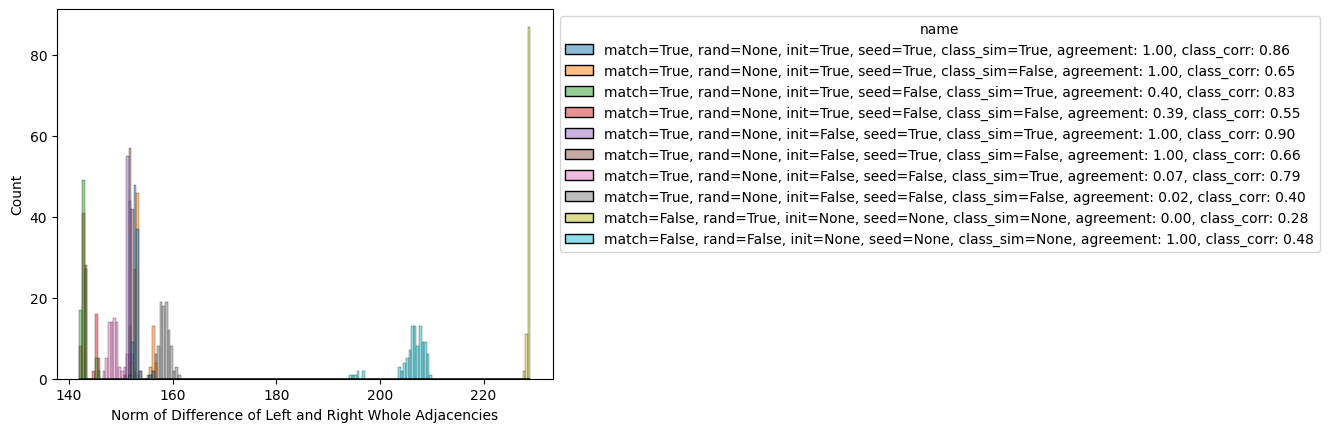

In [39]:
ax_whole = sns.histplot(data=df_whole, x="norm", hue="name", binwidth=0.5)
ax_whole.set_xlabel("Norm of Difference of Left and Right Whole Adjacencies")
sns.move_legend(ax_whole, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(folder / "graph_match_whole_hist.png")

Find proportion of agreement of labels between the left and right skids for all the cases (match/total)

Run green param combinations bunch of times and use best adjs based on norms/agreement

Use adjs to do paired density/sbm testing

Read second paper

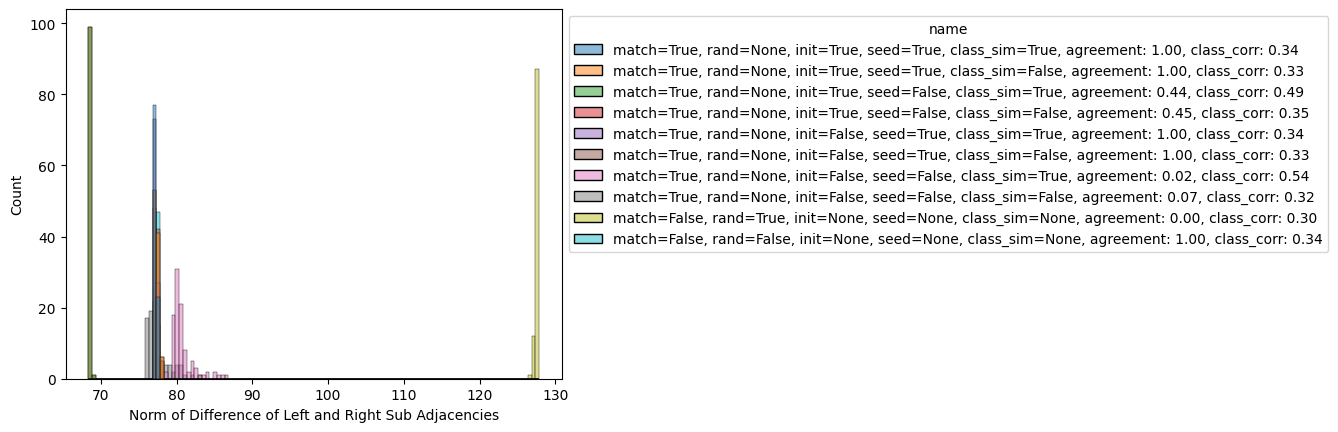

In [40]:
ax_sub = sns.histplot(data=df_sub, x="norm", hue="name", binwidth=0.5)
ax_sub.set_xlabel("Norm of Difference of Left and Right Sub Adjacencies")
sns.move_legend(ax_sub, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(folder / "graph_match_sub_hist.png")

In [24]:
#find which combination of left right using the init=True, seed=False, class_sim=True for the whole and sub adjs
n_iters_test = 100
for type_adjs in ["whole", "sub"]:
        
        if(type_adjs == "whole"):
            values = whole_values
        elif(type_adjs == "sub"):
            values = sub_values

        left_skids_to_match = values["left_skids_to_match"]
        right_skids_to_match = values["right_skids_to_match"]
        
        #grab the adjs, need them regardless whether we match or not in order to calculate the norm
        left_adjacency = values["left_adj"]
        right_adjacency = values["right_adj"]

        left_labels_to_use = values["left_labels_perm"]
        right_labels_to_use = values["right_labels_perm"]

        #is_init is True
        max_dim = max(len(left_skids_to_match), len(right_skids_to_match))
        #init is an identity matrix the size of the number of non-seeded pairs
        init = np.eye(max_dim)

        #is_class_sim is True
        S = values["class_sim_mat"]
    
        #do graph matching
        ind_left_list = []
        ind_right_list = []
        for i in range(n_iters_test):
            ind_left, ind_right, score, misc = graph_match(left_adjacency, right_adjacency, init=init, S=S)
            ind_left_list.append(ind_left)
            ind_right_list.append(ind_right)
        
        #grab the permuted skids and adjs and labels
        left_matched_skids_list = []
        right_matched_skids_list = []
        left_matched_adj_list = []
        right_matched_adj_list = []
        left_matched_labels_list = []
        right_matched_labels_list = []

        for i in range(len(ind_left_list)):
            left_matched_skids = left_skids_to_match[ind_left_list[i]]
            right_matched_skids = right_skids_to_match[ind_right_list[i]]
            left_matched_adj = left_adjacency[np.ix_(ind_left_list[i], ind_left_list[i])]
            right_matched_adj = right_adjacency[np.ix_(ind_right_list[i], ind_right_list[i])]
            left_matched_labels = left_labels_to_use[ind_left_list[i]]
            right_matched_labels = right_labels_to_use[ind_right_list[i]]

            left_matched_skids_list.append(left_matched_skids)
            right_matched_skids_list.append(right_matched_skids)
            left_matched_adj_list.append(left_matched_adj)
            right_matched_adj_list.append(right_matched_adj)
            left_matched_labels_list.append(left_matched_labels)
            right_matched_labels_list.append(right_matched_labels)
        print(len(left_matched_adj_list))
        print(len(left_matched_labels_list))


        #generate list of dataframes of pairs using the ind lists from graph matching
        pairs_df_list = gen_df_of_pairs(left_skids_to_match, ind_left_list, right_skids_to_match, ind_right_list)
        
        #calculate agreement
        agreement_list = calc_agreement(pairs_df_list, values["left_skids_in_pairs"])
        #print(agreement_list)
        
        #calculate class correspondance
        class_corr_list = calc_class_corr(left_labels_to_use, ind_left_list, right_labels_to_use, ind_right_list)
        print(class_corr_list)
        
        #calculate norm
        norm_list = calc_norm(left_adjacency, ind_left_list, right_adjacency, ind_right_list)
        #print(norm_list)

        #see which when graph matching did best, then save the matched adjs and labels
        best_ind = 0
        high_corr = 0
        for i in range(len(class_corr_list)):
            corr = class_corr_list[i]
            if corr>high_corr:
                best_ind = i
                high_corr = corr
        
        print(best_ind)
        print(high_corr)

        #using best_ind, save the adjs and labels
        best_left_adj = left_matched_adj_list[best_ind]
        best_right_adj = right_matched_adj_list[best_ind]
        best_left_labels = left_matched_labels_list[best_ind]
        best_right_labels = right_matched_labels_list[best_ind]

        best_left_adj = pd.DataFrame(best_left_adj, index=left_matched_skids_list[best_ind], columns=left_matched_skids_list[best_ind])
        best_right_adj = pd.DataFrame(best_right_adj, index=right_matched_skids_list[best_ind], columns=right_matched_skids_list[best_ind])
        best_left_labels = pd.Series(best_left_labels)
        best_right_labels = pd.Series(best_right_labels)

        best_left_adj.to_csv(folder / f"{type_adjs}_best_left_adj.csv", index=False)
        best_right_adj.to_csv(folder / f"{type_adjs}_best_right_adj.csv", index=False)
        best_left_labels.to_csv(folder / f"{type_adjs}_best_left_labels.csv")
        best_right_labels.to_csv(folder / f"{type_adjs}_best_right_labels.csv")

100
100
[0.8204570184983678, 0.8226332970620239, 0.8248095756256801, 0.8313384113166485, 0.8193688792165397, 0.8280739934711643, 0.8161044613710555, 0.8204570184983678, 0.8400435255712732, 0.8411316648531012, 0.8269858541893362, 0.8324265505984766, 0.8280739934711643, 0.8258977149075082, 0.8117519042437432, 0.8335146898803046, 0.8346028291621328, 0.8258977149075082, 0.8226332970620239, 0.8193688792165397, 0.8346028291621328, 0.8280739934711643, 0.8335146898803046, 0.8313384113166485, 0.8128400435255713, 0.8335146898803046, 0.8378672470076169, 0.8117519042437432, 0.8280739934711643, 0.8509249183895539, 0.8215451577801959, 0.8226332970620239, 0.8378672470076169, 0.8324265505984766, 0.8193688792165397, 0.8248095756256801, 0.8269858541893362, 0.8378672470076169, 0.8226332970620239, 0.823721436343852, 0.8280739934711643, 0.8215451577801959, 0.8313384113166485, 0.8313384113166485, 0.8258977149075082, 0.8335146898803046, 0.8302502720348205, 0.8204570184983678, 0.8215451577801959, 0.8269858541

In [25]:
#throw out the neurons in which the left and right labels do not align
from pkg.platy import load_best_left_adj_with_class, load_best_right_adj_with_class

best_left_adj, best_left_labels = load_best_left_adj_with_class()
best_right_adj, best_right_labels = load_best_right_adj_with_class()

best_left_labels = np.array(best_left_labels)
best_right_labels = np.array(best_right_labels)

#find the inds where the labels are equal
label_agreement_list = best_left_labels == best_right_labels
label_agreement_list_true = np.where(label_agreement_list==True)

#use the inds to subset the adjs and labels
best_left_adj_align_rows = best_left_adj.iloc[label_agreement_list_true]
best_left_adj_align_index = best_left_adj_align_rows.index
best_left_adj_align = best_left_adj_align_rows.loc[:, best_left_adj_align_index]

best_right_adj_align_rows = best_right_adj.iloc[label_agreement_list_true]
best_right_adj_align_index = best_right_adj_align_rows.index
best_right_adj_align = best_right_adj_align_rows.loc[:, best_right_adj_align_index]

best_left_labels_align = best_left_labels[label_agreement_list_true]
best_right_labels_align = best_right_labels[label_agreement_list_true]

best_left_labels_align = pd.Series(best_left_labels_align)
best_right_labels_align = pd.Series(best_right_labels_align)

best_left_adj_align.to_csv(folder / "whole_best_left_adj_align.csv", index=False)
best_right_adj_align.to_csv(folder / "whole_best_right_adj_align.csv", index=False)
best_left_labels_align.to_csv(folder / "whole_best_left_labels_align.csv")
best_right_labels_align.to_csv(folder / "whole_best_right_labels_align.csv")

How should I deal with the labels that are not aligned when doing the sbm paired testing?

Do 100 runs instead of 10 for the for loops and make histplots again

Throw out the labels and corresponding neurons in the adjs that don't match

Do density and sbm analysis: do everything possible with left and right adjs for each

In [ ]:
whole_values = init_skids_and_adjs_v2(type="whole")
whole_left_adj = whole_values["left_adj"]
whole_right_adj = whole_values["right_adj"]
whole_left_skids_in_pairs = whole_values["left_skids_in_pairs"]
whole_left_skids_to_match = whole_values["left_skids_to_match"]
whole_right_skids_to_match = whole_values["right_skids_to_match"]
num_pairs = whole_values["num_pairs"]
whole_class_sim = whole_values["class_sim_mat"]
whole_left_labels = whole_values["left_labels_perm"]
whole_right_labels = whole_values["right_labels_perm"]
whole_S = whole_values["class_sim_mat"]

In [ ]:
whole_left_labels = whole_values["left_labels_perm"]
whole_right_labels = whole_values["right_labels_perm"]

print(len(whole_left_labels))
print(len(whole_right_labels))

967
919


In [ ]:
whole_S.shape

(967, 919)

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(whole_S, maximize=True)
whole_S[row_ind, col_ind].sum()

912

In [ ]:
#max class agreement
left_ind_list = []
right_ind_list = []
for i in range(2):
    left_ind, right_ind, _, _ = graph_match(np.zeros((967, 967)), np.zeros((919, 919)), S=whole_S)
    left_ind_list.append(left_ind)
    right_ind_list.append(right_ind)
print(calc_class_corr(whole_left_labels, left_ind_list, whole_right_labels, right_ind_list))

pairs_df_list = gen_df_of_pairs(whole_left_skids_to_match, left_ind_list, whole_right_skids_to_match, right_ind_list)
print(calc_agreement(pairs_df_list, values["left_skids_in_pairs"]))

print(calc_norm(whole_left_adj, left_ind_list, whole_right_adj, right_ind_list))


[0.9923830250272034, 0.9923830250272034]
[0.004032258064516129, 0.0]
[232.34241971710634, 231.52537657889687]


In [ ]:
partial_match_test = np.stack((np.arange(whole_values["num_pairs"]), np.arange(whole_values["num_pairs"]))).T
max_dim = max(len(whole_left_skids_to_match), len(right_skids_to_match))
init_test = np.eye(max_dim-num_pairs)
init_test_2 = np.eye(max_dim)
S_test = whole_class_sim

In [ ]:
init_test.shape

(712, 712)

In [ ]:
dfs, inds_left, inds_right = match_skid_dims(whole_left_skids_to_match, whole_right_skids_to_match, num_pairs, n_iters)
#print(whole_left_adj_list[0][np.ix_(inds[0], inds[0])].shape)